# Purity and excitation probability comparison

We will use a square wavepacket and compare markovian and wavepacket evolution.

Note:

3dB of squeezing is $r \approx 0.31$


4.5dB of squeezing is $r \approx 0.51$

*JC Re-ran note book 30th april 2021 to save all time data.*

In [1]:
from functools import partial
import pickle
import numpy as np
from scipy.integrate import quad

from tqdm import tqdm_notebook

import pysme.hierarchy as hier
import pysme.integrate as integ

import matplotlib.pyplot as plt
import matplotlib
# #from quantum_utilities.qubits import Id, sigm, sigz, zero
import pickle

In [2]:
# Define Lowering operator and Sigma Z

Id = np.eye(2, dtype=complex)

zero = np.zeros((2,2), dtype=complex)

sigz = np.array([[1, 0], [0, -1]], dtype=complex)

sigx = np.array([[0, 1], [1, 0]], dtype=complex)

sigy = np.array([[0, -1j], [1j, 0]], dtype=complex)

sigm = np.array([[0, 0], [1, 0]], dtype=complex)

In [3]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

def xi_gau(t, Omega, ta):
    return np.power(Omega**2/(2*np.pi), 1/4) * np.exp(-Omega**2*(t - ta)**2/4)

# Match inital decay

In [4]:
# rs = np.arcsinh(np.sqrt(np.arange(5)))
# print('rs', rs)
# print('exp(rs)', np.exp(rs))
# print('sinh(rs)^2', np.sinh(rs)**2)


n_max = 22

Omega = 0 #1.21

# 3dB of squeezing  r \approx =0.31
3 / (20* np.log10(np.e))

# 4.5dB of squeezing r \approx 0.51
r = 4.5/ (20* np.log10(np.e))



r_val_wp = r 

print('r_val_wp', r_val_wp)
#r_val_bb = 0.2335848289126526

mu_val = 0

gam = 1

xi_len = 4

S = Id
L = np.sqrt(gam) * sigm
H = zero

rho0 = (Id + (sigx + sigy)/np.sqrt(2))/2 # np.array([[1, 0], [0, 0]], dtype=complex) # excited state

xi = xi_rect


times = np.linspace(0, xi_len + 2, num=xi_len*30 + 60)

r_val_wp 0.5180816459236602


In [5]:
## M and N params
M_wp = - np.exp(2j*mu_val)* np.sinh(r_val_wp) * np.cosh(r_val_wp)
N_wp = np.sinh(r_val_wp)**2

print('M = ', M_wp)
print('N = ', N_wp)

M =  (-0.6158923855077195-0j)
N =  0.2932990801245072


### Wavepacket

In [6]:
factory = hier.HierarchyIntegratorFactory(2, n_max)
           
integrators = factory.make_uncond_integrator(partial(xi, a=0, b=xi_len), S, L, H, r=r_val_wp, mu=mu_val)

In [7]:
solns = integrators.integrate(rho0, times)

In [8]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

### Vacuum evolution

In [9]:
vac_integrator_object = integ.UncondLindbladIntegrator([L],H)
vac_soln = vac_integrator_object.integrate(rho0, times)

### Markovian Squeezed evolution

here we numerically optimize over the squeeze parameter to match the inital decay of the wavepacket solution

In [10]:
# Wavepacket shape
# TODO: make wavepacket return to vac soln after x>b: f1-> 1 & f2 -> 0
# in the mean time we just wont show evolution past cut off time
def f1(x, a, b, mu, r):
    return np.cosh(r)*np.where(x < a, 0, np.where(x < b, 1, 0))

def f2(x, a, b, mu, r):
    return np.exp(2j*mu)* np.sinh(r)*np.where(x < a, 0, np.where(x < b, 1, 0))


find squeezing amount to match the decay curve over the first 1 unit of time of the wavepacket

In [11]:
stz = 0.0
stp = 1.01
print('the index of t='+str(stz)+' is ', np.argmin((times-stz)**2))
print('the index of t='+str(stp)+' is ', np.argmin((times-stp)**2))

startz = np.argmin((times-stz)**2)
endz = np.argmin((times-stp)**2)
tp = times[startz:endz]
x_wp = solns.get_expectations(sigx, vac_rho(n_max))
y_wp = solns.get_expectations(sigy, vac_rho(n_max))
z_wp = solns.get_expectations(sigz, vac_rho(n_max))
xwp = x_wp[startz:endz]
ywp = y_wp[startz:endz]
zwp = z_wp[startz:endz]


def func(r_val_bb, *params):
    times, L, H, xi_len, mu_val, rho0 , xwp, ywp, zwp, startz, endz = params
    fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
    H_list = [H]
    broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
    markov_soln = broadband_integrator_object.integrate(rho0, times)
    x_m = markov_soln.get_expectations(sigx)
    y_m = markov_soln.get_expectations(sigy)
    z_m = (markov_soln.get_expectations(sigz) + 1)/2
    xm = x_m[startz:endz]
    ym = y_m[startz:endz]
    zm = z_m[startz:endz]
    return np.sum( (ywp - ym)**2) + np.sum( (xwp - xm)**2)

the index of t=0.0 is  0
the index of t=1.01 is  30


In [12]:
from scipy import optimize
paramz = (times, L, H, xi_len, mu_val, rho0, xwp, ywp, zwp, startz, endz)
rangez = (0.0001,0.53)

soln = optimize.minimize_scalar(func, bracket=None, bounds=rangez, args=paramz)

print(soln)

r_val_bb = soln.x

     fun: 0.009175521394508614
    nfev: 19
     nit: 15
 success: True
       x: 0.09570808577932297


simulate markovian squeezed evolution with  numercially found optimal amount of squeezing

In [13]:
fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
H_list = [H]
broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
markov_soln = broadband_integrator_object.integrate(rho0, times)
x_m = markov_soln.get_expectations(sigx)
y_m = markov_soln.get_expectations(sigy)
z_m = markov_soln.get_expectations(sigz)
xm = x_m[startz:endz]
ym = y_m[startz:endz]
zm = z_m[startz:endz]

In [14]:
ones = 0.7071067811865475*np.ones_like(xm)
zeros = np.zeros_like(xm)

In [15]:
def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [16]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [17]:
save_data = True

timez = times[startz:endz]

filename = "short_time_markov_WP_cmp_data.pickle"

M = - np.exp(2j*mu_val)* np.sinh(r_val_bb) * np.cosh(r_val_bb)
N = np.sinh(r_val_bb)**2

print(N,M)
print(N+M+1/2)
print(N-M+1/2)

data = {'times': times,
        'r_val_wp': r_val_wp,
        'mu_val':mu_val,
        'M_wp':M_wp,
        'N_wp':N_wp, 
        'r_val_bb': r_val_bb,
        'M_bb': M,
        'N_bb': N,
        'xm': markov_soln.get_expectations(sigx),
        'ym': markov_soln.get_expectations(sigy),
        'Pem': ((markov_soln.get_expectations(sigz) + 1)/2),
        'Puritym': (markov_soln.get_purities()),
        'vac_x': vac_soln.get_expectations(sigx),
        'vac_y': vac_soln.get_expectations(sigy),
        'Pevac': ((vac_soln.get_expectations(sigz) + 1)/2),
        'Purityvac': (vac_soln.get_purities()),
        'xwp': solns.get_expectations(sigx, vac_rho(n_max)),
        'ywp': solns.get_expectations(sigy, vac_rho(n_max)),
        'Pewp': ((solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2),
        'Puritywp': solns.get_purities(vac_rho(n_max)),
        'HierarchyTruncation':n_max,
        }


if save_data:
    pickle.dump( data, open( filename, "wb" ) )
    
st_pur_dat = pickle.load(open(filename, "rb"))

0.009188040628679658 (-0.09629361723018783-0j)
(0.4128944233984918+0j)
(0.6054816578588675+0j)


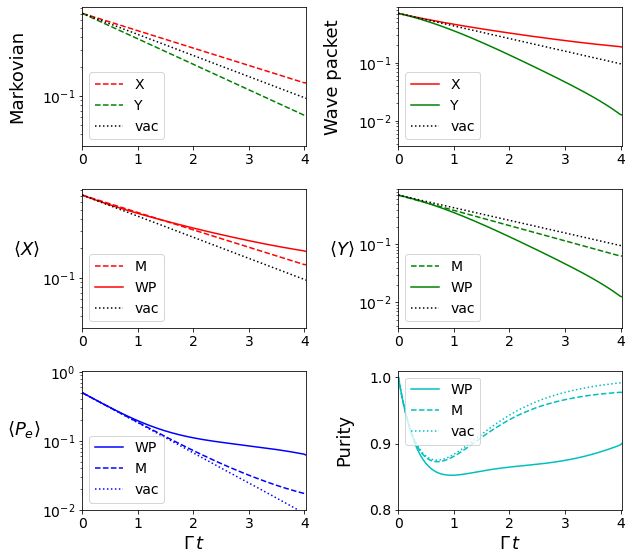

In [18]:

fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(9, 8), sharey=False)

axs[0,0].semilogy(st_pur_dat['times'], st_pur_dat['xm'], label='X',linestyle='--',color='r')
axs[0,0].semilogy(st_pur_dat['times'], st_pur_dat['ym'], label='Y',linestyle='--',color='g')
axs[0,0].semilogy(st_pur_dat['times'], st_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
#axs[1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=14)
axs[0,0].set_ylabel(r'Markovian',labelpad=16)
axs[0,0].set_xlim(0.0, 4.025)
#axs[0,0].set_ylim([4e-1,7.2e-1])
axs[0,0].legend()
axs[0,1].semilogy(st_pur_dat['times'], st_pur_dat['xwp'], label='X',linestyle='-',color='r')
axs[0,1].semilogy(st_pur_dat['times'], st_pur_dat['ywp'], label='Y',linestyle='-',color='g')
axs[0,1].semilogy(st_pur_dat['times'], st_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
axs[0,1].set_ylabel(r'Wave packet',labelpad=16)
#axs[0].set_ylabel(r'',rotation=0,labelpad=14)
#axs[0,1].set_ylim([4e-1,7.2e-1])
axs[0,1].set_xlim(0.0, 4.025)
#axs[0,1].set_title('Wave packet')
axs[0,1].legend()



axs[1,1].semilogy(st_pur_dat['times'], st_pur_dat['ym'], label='M',linestyle='--',color='g')
axs[1,1].semilogy(st_pur_dat['times'], st_pur_dat['ywp'], label='WP',linestyle='-',color='g')
axs[1,1].semilogy(st_pur_dat['times'], st_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
axs[1,1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=16)
axs[1,1].set_xlim(0.0, 4.025)
#axs[1,1].set_ylim([4e-1,7.2e-1])
axs[1,1].legend()
axs[1,0].semilogy(st_pur_dat['times'], st_pur_dat['xm'], label='M',linestyle='--',color='r')
axs[1,0].semilogy(st_pur_dat['times'], st_pur_dat['xwp'], label='WP',linestyle='-',color='r')
axs[1,0].semilogy(st_pur_dat['times'], st_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
axs[1,0].set_ylabel(r'$\langle X \rangle$',rotation=0,labelpad=16)
#axs[1,0].set_ylim([4e-1,7.2e-1])
axs[1,0].set_xlim(0.0, 4.025)
#axs[0].set_yticks(minor=True)
axs[1,0].legend()



rwp_plot = np.round(st_pur_dat['r_val_wp'],3)
rbb_plot = np.round(st_pur_dat['r_val_bb'],3)

#axs[2,0].plot(times, xi_rect(times,a=0, b=xi_len),label=r'$\xi(t)$',linestyle='--',color='k')
axs[2,0].semilogy(st_pur_dat['times'], st_pur_dat['Pewp'],label='WP',linestyle='-',color='b')
axs[2,0].semilogy(st_pur_dat['times'], st_pur_dat['Pem'], label='M',linestyle='--',color='b')
axs[2,0].semilogy(st_pur_dat['times'], st_pur_dat['Pevac'], label='vac',linestyle=':',color='b')
#axs[0].set_yscale('log')
axs[2,0].set_xlim(0.0, 4.025)
axs[2,0].set_ylim(1e-2, 1.05) 
axs[2,0].set_ylabel(r'$\langle P_e \rangle $',rotation=0,labelpad=18) 
axs[2,0].set_xlabel(r'$\Gamma\, t $')
axs[2,0].legend()

#axs[2,1].plot(times, solns.get_purities(vac_rho(n_max)),label='WP r =' + str(rwp_plot),linestyle='-',color='c')
#axs[2,1].plot(times, markov_soln.get_purities(),label='Markov r = ' + str(rbb_plot), linestyle='--',color='c')
axs[2,1].plot(st_pur_dat['times'], st_pur_dat['Puritywp'],label='WP',linestyle='-',color='c')
axs[2,1].plot(st_pur_dat['times'], st_pur_dat['Puritym'],label='M', linestyle='--',color='c')
axs[2,1].plot(st_pur_dat['times'], st_pur_dat['Purityvac'],label='vac',linestyle=':',color='c')
#f3_ax2.set_yscale('log')
axs[2,1].set_xlim(0.0, 4.025)
axs[2,1].set_ylim(0.8, 1.01) 
axs[2,1].set_xlabel(r'$\Gamma\, t $')
axs[2,1].set_ylabel(r'Purity',labelpad=16)
axs[2,1].legend()#loc='upper left')


plt.tight_layout()

name='wp_v_markov_cmp'
#plt.savefig(name+'.pdf',bbox_inches = 'tight', pad_inches = 0.01)

In [19]:
#M and N params
M = - np.exp(2j*mu_val)* np.sinh(r_val_bb) * np.cosh(r_val_bb)
N = np.sinh(r_val_bb)**2

print(N,M)
print(N+M+1/2)
print(N-M+1/2)

print()
print('WP N and M')
print(N_wp+M_wp+1/2)
print(N_wp-M_wp+1/2)

print()
print('Ratio of markov to WP N and M')
print((N_wp+M_wp+1/2)/(N+M+1/2))
print((N_wp-M_wp+1/2)/(N-M+1/2))

0.009188040628679658 (-0.09629361723018783-0j)
(0.4128944233984918+0j)
(0.6054816578588675+0j)

WP N and M
(0.1774066946167877+0j)
(1.4091914656322269+0j)

Ratio of markov to WP N and M
(0.4296659982873378+0j)
(2.3273891906411754+0j)


In [20]:
# expected modification of Z decay rate relative to vac
print('Markov ',2*N+1)
print('WP ',2*N_wp+1)


Markov  1.0183760812573592
WP  1.5865981602490145


In [21]:
np.round(2.3273891,3)

2.327

In [22]:
np.exp(r_val_bb)
np.exp(-r_val_bb)


0.9087292483446231

In [23]:
print(M_wp/M)
print(N_wp/N)

(6.395983484922391-0j)
31.921830995065477


# Match steady state exitation probablity

In [24]:
# rs = np.arcsinh(np.sqrt(np.arange(5)))
# print('rs', rs)
# print('exp(rs)', np.exp(rs))
# print('sinh(rs)^2', np.sinh(rs)**2)


n_max = 22

Omega = 0 #1.21

# 3dB of squeezing  r \approx =0.31
3 / (20* np.log10(np.e))

# 4.5dB of squeezing r \approx 0.51
r = 4.5/ (20* np.log10(np.e))



r_val_wp = r 

#r_val_bb = 0.2335848289126526

mu_val = 0

gam = 1

xi_len = 9


S = Id
L = np.sqrt(gam) * sigm
H = zero


rho0 = (Id + (sigx + sigy)/np.sqrt(2))/2
#np.array([[1, 0], [0, 0]], dtype=complex) # excited state
#

xi = xi_rect



times = np.linspace(0, xi_len + 2, num=xi_len*30 + 60)



In [25]:
print(np.trace(rho0@sigx))
print(np.trace(rho0@sigy))
print(np.trace(rho0@sigz))

(0.7071067811865475+0j)
(0.7071067811865475+0j)
0j


In [26]:
# wavepacket 

factory = hier.HierarchyIntegratorFactory(2, n_max)
           
integrators = factory.make_uncond_integrator(partial(xi, a=0, b=xi_len), S, L, H, r=r_val_wp, mu=mu_val)

solns = integrators.integrate(rho0, times)

In [27]:
# vaccum
vac_integrator_object = integ.UncondLindbladIntegrator([L],H)
vac_soln = vac_integrator_object.integrate(rho0, times)

In [28]:
stz = 5.0
stp = 9.0
print('the index of t='+str(stz)+' is ', np.argmin((times-stz)**2))
print('the index of t='+str(stp)+' is ', np.argmin((times-stp)**2))

startz = np.argmin((times-stz)**2)
endz = np.argmin((times-stp)**2)
tp = times[startz:endz]
x_wp = solns.get_expectations(sigx, vac_rho(n_max))
y_wp = solns.get_expectations(sigy, vac_rho(n_max))
z_wp = solns.get_expectations(sigz, vac_rho(n_max))
xwp = x_wp[startz:endz]
ywp = y_wp[startz:endz]
zwp = (z_wp[startz:endz]+1)/2


def func(r_val_bb, *params):
    times, L, H, xi_len, mu_val, rho0 , xwp, ywp, zwp, startz, endz = params
    fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
    H_list = [H]
    broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
    markov_soln = broadband_integrator_object.integrate(rho0, times)
    x_m = markov_soln.get_expectations(sigx)
    y_m = markov_soln.get_expectations(sigy)
    z_m = (markov_soln.get_expectations(sigz) + 1)/2
    xm = x_m[startz:endz]
    ym = y_m[startz:endz]
    zm = z_m[startz:endz]
    return np.sum( (zwp - zm)**2)

the index of t=5.0 is  150
the index of t=9.0 is  269


In [29]:
from scipy import optimize
paramz = (times, L, H, xi_len, mu_val, rho0, xwp, ywp, zwp, startz, endz)
rangez = (0.0001,0.53)

soln = optimize.minimize_scalar(func, bracket=None, bounds=rangez, args=paramz)

print(soln)

r_val_bb = soln.x

     fun: 0.0027187948894989307
    nfev: 18
     nit: 14
 success: True
       x: 0.21411470432227903


In [30]:
fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)

L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]

H_list = [H]

broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
markov_soln = broadband_integrator_object.integrate(rho0, times)

In [31]:
x_m = markov_soln.get_expectations(sigx)
y_m = markov_soln.get_expectations(sigy)
z_m = (markov_soln.get_expectations(sigz) + 1)/2 # actualy Pe

In [32]:
save_data = True



filename = "long_time_markov_WP_cmp_data.pickle"

M = - np.exp(2j*mu_val)* np.sinh(r_val_bb) * np.cosh(r_val_bb)
N = np.sinh(r_val_bb)**2

print(N,M)
print(N+M+1/2)
print(N-M+1/2)

data = {'times': times,
        'r_val_wp': r_val_wp,
        'mu_val':mu_val,
        'M_wp':M_wp,
        'N_wp':N_wp, 
        'r_val_bb': r_val_bb,
        'M_bb': M,
        'N_bb': N,
        'xm': markov_soln.get_expectations(sigx),
        'ym': markov_soln.get_expectations(sigy),
        'Pem': ((markov_soln.get_expectations(sigz) + 1)/2),
        'Puritym': (markov_soln.get_purities()),
        'vac_x': vac_soln.get_expectations(sigx),
        'vac_y': vac_soln.get_expectations(sigy),
        'Pevac': ((vac_soln.get_expectations(sigz) + 1)/2),
        'Purityvac': (vac_soln.get_purities()),
        'xwp': solns.get_expectations(sigx, vac_rho(n_max)),
        'ywp': solns.get_expectations(sigy, vac_rho(n_max)),
        'Pewp': ((solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2),
        'Puritywp': solns.get_purities(vac_rho(n_max)),
        'HierarchyTruncation':n_max,
        }

if save_data:
    pickle.dump( data, open( filename, "wb" ) )
    
lt_pur_dat = pickle.load(open(filename, "rb"))

0.046549994416735054 (-0.22071904402867715-0j)
(0.32583095038805787+0j)
(0.7672690384454122+0j)


In [33]:
len(lt_pur_dat['xm'])

330

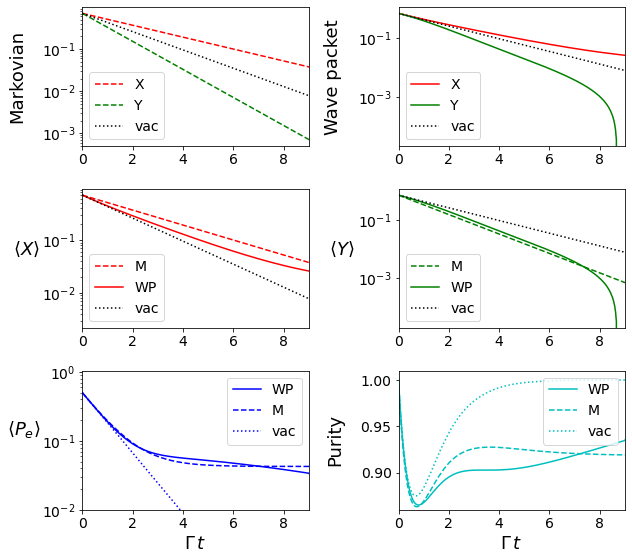

In [34]:

fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(9, 8), sharey=False)

axs[0,0].semilogy(lt_pur_dat['times'], lt_pur_dat['xm'], label='X',linestyle='--',color='r')
axs[0,0].semilogy(lt_pur_dat['times'], lt_pur_dat['ym'], label='Y',linestyle='--',color='g')
axs[0,0].semilogy(lt_pur_dat['times'], lt_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
#axs[1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=14)
axs[0,0].set_ylabel(r'Markovian',labelpad=16)
axs[0,0].set_xlim([0,9])
#axs[0,0].set_ylim([4e-1,7.2e-1])
axs[0,0].legend()
axs[0,1].semilogy(lt_pur_dat['times'], lt_pur_dat['xwp'], label='X',linestyle='-',color='r')
axs[0,1].semilogy(lt_pur_dat['times'], lt_pur_dat['ywp'], label='Y',linestyle='-',color='g')
axs[0,1].semilogy(lt_pur_dat['times'], lt_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
axs[0,1].set_ylabel(r'Wave packet',labelpad=16)
axs[0,1].set_xlim([0,9])
#axs[0].set_ylabel(r'',rotation=0,labelpad=14)
#axs[0,1].set_ylim([4e-1,7.2e-1])
#axs[0,1].set_title('Wave packet')
axs[0,1].legend()



axs[1,1].semilogy(lt_pur_dat['times'], lt_pur_dat['ym'], label='M',linestyle='--',color='g')
axs[1,1].semilogy(lt_pur_dat['times'], lt_pur_dat['ywp'], label='WP',linestyle='-',color='g')
axs[1,1].semilogy(lt_pur_dat['times'], lt_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
axs[1,1].set_ylabel(r'$\langle Y \rangle$',rotation=0,labelpad=16)
#axs[1,1].set_ylim([4e-1,7.2e-1])
axs[1,1].set_xlim([0,9])
axs[1,1].legend()
axs[1,0].semilogy(lt_pur_dat['times'], lt_pur_dat['xm'], label='M',linestyle='--',color='r')
axs[1,0].semilogy(lt_pur_dat['times'], lt_pur_dat['xwp'], label='WP',linestyle='-',color='r')
axs[1,0].semilogy(lt_pur_dat['times'], lt_pur_dat['vac_x'], label='vac',linestyle=':',color='k')
axs[1,0].set_ylabel(r'$\langle X \rangle$',rotation=0,labelpad=16)
axs[1,0].set_xlim([0,9])
#axs[1,0].set_ylim([4e-1,7.2e-1])
#axs[0].set_yticks(minor=True)
axs[1,0].legend()



rwp_plot = np.round(lt_pur_dat['r_val_wp'],3)
rbb_plot = np.round(lt_pur_dat['r_val_bb'],3)

#axs[2,0].plot(times, xi_rect(times,a=0, b=xi_len),label=r'$\xi(t)$',linestyle='--',color='k')
axs[2,0].semilogy(lt_pur_dat['times'], lt_pur_dat['Pewp'],label='WP',linestyle='-',color='b')
axs[2,0].semilogy(lt_pur_dat['times'], lt_pur_dat['Pem'], label='M',linestyle='--',color='b')
axs[2,0].semilogy(lt_pur_dat['times'], lt_pur_dat['Pevac'], label='vac',linestyle=':',color='b')
#axs[0].set_yscale('log')
axs[2,0].set_xlim(0.0, 9)
axs[2,0].set_ylim(1e-2, 1.05) 
axs[2,0].set_ylabel(r'$\langle P_e \rangle $',rotation=0,labelpad=18) 
axs[2,0].set_xlabel(r'$\Gamma\, t $')
axs[2,0].legend()

#axs[2,1].plot(times, solns.get_purities(vac_rho(n_max)),label='WP r =' + str(rwp_plot),linestyle='-',color='c')
#axs[2,1].plot(times, markov_soln.get_purities(),label='Markov r = ' + str(rbb_plot), linestyle='--',color='c')
axs[2,1].plot(lt_pur_dat['times'], lt_pur_dat['Puritywp'],label='WP',linestyle='-',color='c')
axs[2,1].plot(lt_pur_dat['times'], lt_pur_dat['Puritym'],label='M', linestyle='--',color='c')
axs[2,1].plot(lt_pur_dat['times'], lt_pur_dat['Purityvac'],label='vac',linestyle=':',color='c')
#f3_ax2.set_yscale('log')
axs[2,1].set_xlim(0.0, 9)
axs[2,1].set_ylim(0.86, 1.01) 
axs[2,1].set_xlabel(r'$\Gamma\, t $')
axs[2,1].set_ylabel(r'Purity',labelpad=16)
axs[2,1].legend(loc='upper right')


plt.tight_layout()

name='wp_v_markov_cmp_exitation'
#plt.savefig(name+'.pdf',bbox_inches = 'tight', pad_inches = 0.01)

In [35]:
#M and N params
M = - np.exp(2j*mu_val)* np.sinh(r_val_bb) * np.cosh(r_val_bb)
N = np.sinh(r_val_bb)**2

print(N,M)
print(N+M+1/2)
print(N-M+1/2)

print()
print('WP N and M')
print(N_wp+M_wp+1/2)
print(N_wp-M_wp+1/2)

print()
print('Ratio of markov to WP N and M')
print((N_wp+M_wp+1/2)/(N+M+1/2))
print((N_wp-M_wp+1/2)/(N-M+1/2))

0.046549994416735054 (-0.22071904402867715-0j)
(0.32583095038805787+0j)
(0.7672690384454122+0j)

WP N and M
(0.1774066946167877+0j)
(1.4091914656322269+0j)

Ratio of markov to WP N and M
(0.5444746559696064+0j)
(1.836632778102755+0j)


In [36]:
r_val_bb

0.21411470432227903

In [37]:
np.round(1.8366,3)

1.837

In [38]:
(N+M+1/2)/1.837

(0.17737123047798467+0j)

In [39]:
1.837*(N-M+1/2)

(1.4094732236242222+0j)